This script will pre process the modis products to compare to our predictions, reference and gabam as bar plots for burned area.  Landsat is processed in other scripts.  I will make the bar plots in this script and calculate omission/comission for us and gabam. 

In [1]:
library(terra)
library(sf)
library(tidyverse)

out_path = '/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons'
dir.create(out_path, recursive = T)

#path to ak
ak = read_sf('/explore/nobackup/people/spotter5/auxillary/Features/Alaska/Boundaries/alaska.shp')

#path to canada
ca = read_sf('/explore/nobackup/people/spotter5/auxillary/Features/Canada/Provinces/Canada_Provinces.shp') 

#path to modis ba
mcd64a1_ba_path = '/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/mcd64a1_translated'
fire_cci_ba_path = '/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/fire_cci_merged'
abovefed_path = '/explore/nobackup/people/spotter5/combustion/final_files2/translate'


#files to loop through
years = c(2004, 2005, 2010, 2014, 2015)

#for combination of all years
combined = list()

for(year in years){
    
    #fire cci
    fire_cci = rast(file.path(fire_cci_ba_path, paste0(year, '.tif')))[[1]]
    fire_cci[fire_cci == 0] = NA
    fire_cci[fire_cci > 0] = 1
    
    #mcdg4a1 collection 6
    mcd64a1 = rast(file.path(mcd64a1_ba_path, paste0('mcd64a1_', year, '.tif')))[[1]]
    mcd64a1[mcd64a1 == 0] = NA
    mcd64a1[mcd64a1 > 0] = 1
    
    #abovefed
    above = rast(file.path(abovefed_path, paste0('translated_', year, '.tif')))[[1]]
    # above[above == 0] = NA
    # above[above > 0] = 1

    #get cellsize
    fire_cci_res = xres(fire_cci)
    mcd64a1_res = xres(mcd64a1)
    above_res = xres(above)
    
    
    #convert to areas in square meters
    fire_cci = fire_cci * fire_cci_res^2
    mcd64a1 = mcd64a1 * mcd64a1_res^2
    above = above * above_res^2
        
    #project shapefiles
    ak_proj = ak %>% st_transform(crs(fire_cci, proj = T))
    ca_proj = ca %>% st_transform(crs(fire_cci, proj = T))
    
    #extract ak
    fire_cci_ak = crop(fire_cci, vect(ak_proj))
    fire_cci_ak = mask(fire_cci, vect(ak_proj))

    mcd64a1_ak = crop(mcd64a1, vect(ak_proj))
    mcd64a1_ak = mask(mcd64a1, vect(ak_proj))
    
    above_ak = crop(above, vect(ak_proj))
    above_ak = mask(above, vect(ak_proj))

    
    #extract ca
    fire_cci_ca = crop(fire_cci, vect(ca_proj))
    fire_cci_ca = mask(fire_cci, vect(ca_proj))

    mcd64a1_ca = crop(mcd64a1, vect(ca_proj))
    mcd64a1_ca = mask(mcd64a1, vect(ca_proj))
    
    above_ca = crop(above, vect(ca_proj))
    above_ca = mask(above, vect(ca_proj))

    
    #get all values in tibble
    fire_cci_ak = tibble(Area = values(fire_cci_ak, mat = F)) %>% drop_na()
    fire_cci_ak = fire_cci_ak %>% mutate(Class = 'Fire_CCI', AOI = 'AK')
                                         
    fire_cci_ca = tibble(Area = values(fire_cci_ca, mat = F)) %>% drop_na()
    fire_cci_ca = fire_cci_ca %>% mutate(Class = 'Fire_CCI', AOI = 'CA')
                                         
    mcd64a1_ak = tibble(Area = values(mcd64a1_ak, mat = F)) %>% drop_na()
    mcd64a1_ak = mcd64a1_ak %>% mutate(Class = 'MCD64A1', AOI = 'AK')
                                         
    mcd64a1_ca = tibble(Area = values(mcd64a1_ca, mat = F)) %>% drop_na()
    mcd64a1_ca = mcd64a1_ca %>% mutate(Class = 'MCD64A1', AOI = 'CA')
    
    above_ak = tibble(Area = values(above_ak, mat = F)) %>% drop_na()
    above_ak = above_ak %>% mutate(Class = 'ABoVE-FED', AOI = 'AK')
                                         
    above_ca = tibble(Area = values(above_ca, mat = F)) %>% drop_na()
    above_ca = above_ca %>% mutate(Class = 'ABoVE-FED', AOI = 'CA')
    
    #combine
    final = bind_rows(list(fire_cci_ak, fire_cci_ca, mcd64a1_ak, mcd64a1_ca, above_ak, above_ca))
    final$Year = year
    
    combined[[length(combined) + 1]] = final
    
    print(year)                              
    

}
  
combined = bind_rows(combined)
write_csv(combined, file.path(out_path, 'modis.csv'))

#start loop, clip ak and canada so we can compare to mtbs and nbac.  We will also combine

terra 1.5.21

Linking to GEOS 3.11.0, GDAL 3.5.2, PROJ 9.0.1; sf_use_s2() is TRUE


Linked against: 3.11.0-CAPI-1.17.0 compiled against: 3.10.3-CAPI-1.16.1

It is probably a good idea to reinstall sf, and maybe rgeos and rgdal too

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::arrow() masks terra::arrow()
✖ tidyr::extract() masks terra::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ dplyr::src()     masks terra::src()
Warning message in dir.create(out_path, recursive = T):
“'/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons' already exists”


ERROR: Error: [crop] extents do not overlap


In [3]:
't'

[1] "t"

Now make graphs of the fire_cci vs mcd64a1 per year

Rows: 20 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Class, AOI
dbl (2): Year, Area

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Class', 'AOI'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Class'. You can override using the
`.groups` argument.
Warning message in dir.create(out, recursive = T):
“'/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/figures/area_bar_plots' already exists”


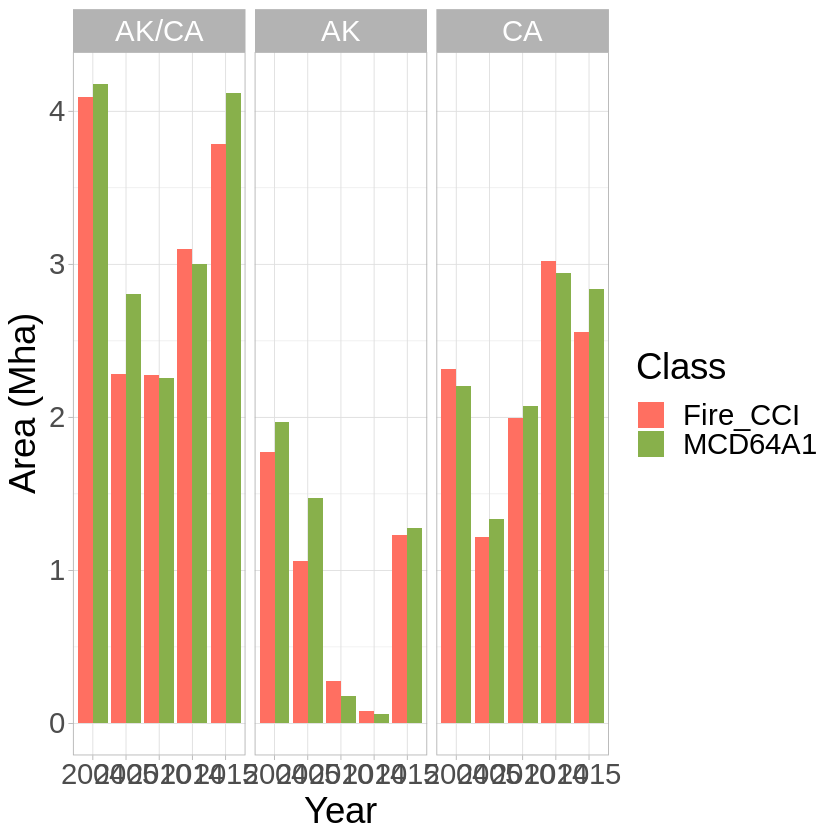

In [3]:
library(tidyverse)

# modis = read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons/modis.csv')
modis = read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons/modis_ee.csv')
#group by Year, AOI and Class and sum area, then turn from m2 to Mha
modis = modis %>% 
        group_by(Class, AOI, Year) %>% 
        dplyr::summarize(Area = sum(Area)) #%>%
        #mutate(Area = Area * 0.0001 / 1e6)

#now get combined ak and ca
comb = modis %>% 
       group_by(Class, Year) %>% 
       dplyr::summarize(Area = sum(Area)) %>%
       mutate(AOI = 'AK/CA') %>%
       select(names(modis))

modis = bind_rows(modis, comb)

modis = modis %>% mutate(AOI = factor(AOI, levels = c('AK/CA', 'AK', 'CA')))

#since we only have specific years make bar plots where the bars are next to each other for Fire_CCI and MCD64A1, the facets are AK vs CA vs Combined and\
#along the x axis is years
out = "/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/figures/area_bar_plots"
dir.create(out, recursive = T)

p = ggplot(data = modis, aes(x = as.factor(Year), y = Area, fill = Class)) + 
         geom_bar(stat = 'identity', position = position_dodge())  +
         scale_fill_manual(values = c('#FF6F61', '#88B04B', 'purple')) + 

         facet_wrap(~AOI, ncol = 3) + 
         theme_light() +   
         labs(x = 'Year', y = 'Area (Mha)') + 
         theme(text=element_text(size=22)) 
p
ggsave(p, filename = file.path(out, 'modis.png'), device = "png", dpi = 150, width = 15, height = 12)


In [2]:
modis


Class,AOI,Year,Area
<chr>,<fct>,<dbl>,<dbl>
ABoVE-FED,AK,2004,2.40734027
ABoVE-FED,AK,2005,1.90831462
ABoVE-FED,AK,2010,0.32719478
ABoVE-FED,AK,2014,0.07105440
ABoVE-FED,AK,2015,1.79714449
ABoVE-FED,CA,2004,3.40179584
ABoVE-FED,CA,2005,2.03616386
ABoVE-FED,CA,2010,3.08613143
ABoVE-FED,CA,2014,4.19751292


Now lets do landsat, note we only have 2004 and 2005 as full years and GABAM has an issue in AK unfortunatley which will need to be fixed

In [2]:
#read in all landsat
# land = list.files('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons/landsat', full.names = T, pattern = "*.csv") %>%
         # map_df(~read_csv(.)) %>%
         # mutate(Area = as.character(Area))
library(tidyverse)

in_files = list.files('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons/landsat_VI2', full.names = F, pattern = "*.csv")

land = list()
for(f in in_files){
    
     df = read_csv(file.path('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons/landsat_VI2', f))
    
    if(nrow(df) > 0){
    
    
         #get col types and ensure Area is numeric
        # test = df %>% summarise_all(class)
        # df = df %>% filter(Area == 'numeric')
        land[[length(land) + 1]] = df
     }
     
     
    
}

land = bind_rows(land)

head(land)

write_csv(land, '/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons/landsat_VI2.csv')


# #group by Year, AOI and Class and sum area, then turn from m2 to Mha
# land = land %>% 
#         group_by(Class, AOI, Year) %>% 
#         dplyr::summarize(Area = sum(Area)) %>%
#         mutate(Area = Area * 0.0001 / 1e6)

# #now get combined ak and ca
# comb = land %>% 
#        mutate(Class = ifelse(Class %in% c('MTBS', 'NBAC'), 'MTBS/NBAC', Class)) %>%
#        group_by(Class, Year) %>% 
#        dplyr::summarize(Area = sum(Area)) %>%
#        mutate(AOI = 'AK/CA') %>%
#        select(names(land))

# land = bind_rows(land, comb)

# land = land %>% mutate(AOI = factor(AOI, levels = c('AK/CA', 'AK', 'CA')))

# out = "/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/figures/area_bar_plots"
# dir.create(out, recursive = T)

# p = ggplot(data = land, aes(x = as.factor(Year), y = Area, fill = Class)) + 
#          geom_bar(stat = 'identity', position = position_dodge())  +
#          facet_wrap(~AOI, ncol = 3) + 
#          theme_light() +   
#          labs(x = 'Year', y = 'Area (Mha)') + 
#          theme(text=element_text(size=22)) 

# ggsave(p, filename = file.path(out, 'landsat.png'), device = "png", dpi = 150, width = 15, height = 12)


# land

Rows: 0 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Area, Class, AOI, Year

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 0 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Area, Class, AOI, Year

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 0 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Area, Class, AOI, Year

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 0 Columns: 4
── Column specification ───────────────────────────────────────────────────

Area,Class,AOI,Year
<dbl>,<chr>,<chr>,<dbl>
900,Us,AK,2004
900,Us,AK,2004
900,Us,AK,2004
900,Us,AK,2004
900,Us,AK,2004
900,Us,AK,2004


In [3]:
't'

[1] "t"

In [1]:
library(tidyverse)
land = read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons/landsat_VI2.csv')
unique(land$Class)

#right now not worried about omissions commission stuff
land2 = land %>% filter(Class %in% c('Us', 'GABAM', 'MTBS', 'NBAC'))

#group by Year, AOI and Class and sum area, then turn from m2 to Mha
land2 = land2 %>% 
        group_by(Class, AOI, Year) %>% 
        dplyr::summarize(Area = sum(Area)) %>%
        mutate(Area = Area * 0.0001 / 1e6)

land2 = land2 %>% mutate(AOI = ifelse(AOI == 'AK', 'Alaska', 'Canada'))
#now get combined ak and ca
comb = land2 %>% 
       mutate(Class = ifelse(Class %in% c('MTBS', 'NBAC'), 'MTBS/NBAC', Class)) %>%
       group_by(Class, Year) %>% 
       dplyr::summarize(Area = sum(Area)) %>%
       mutate(AOI = 'AK/CA') %>%
       select(names(land))

land2 = bind_rows(land2, comb)

land2 = land2 %>% mutate(AOI = factor(AOI, levels = c('AK/CA', 'Alaska', 'Canada')))

out = "/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/figures/area_bar_plots"
dir.create(out, recursive = T)

land2 = land2 %>% mutate(Class = ifelse(Class %in% c('MTBS', 'NBAC', 'MTBS/NBAC'), 'Reference Polygons', Class))
                         


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 1189030650 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Class, AOI
dbl (2): Area, Year

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Us"                 "GABAM"              "MTBS"              
 [4] "Us-Intersection"    "Us-Have"            "Us-Not"            
 [7] "GABAM-Intersection" "GABAM-Have"         "GABAM-Not"         
[10] "NBAC"

`summarise()` has grouped output by 'Class', 'AOI'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Class'. You can override using the
`.groups` argument.
Warning message in dir.create(out, recursive = T):
“'/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/figures/area_bar_plots' already exists”


In [8]:
't'

[1] "t"

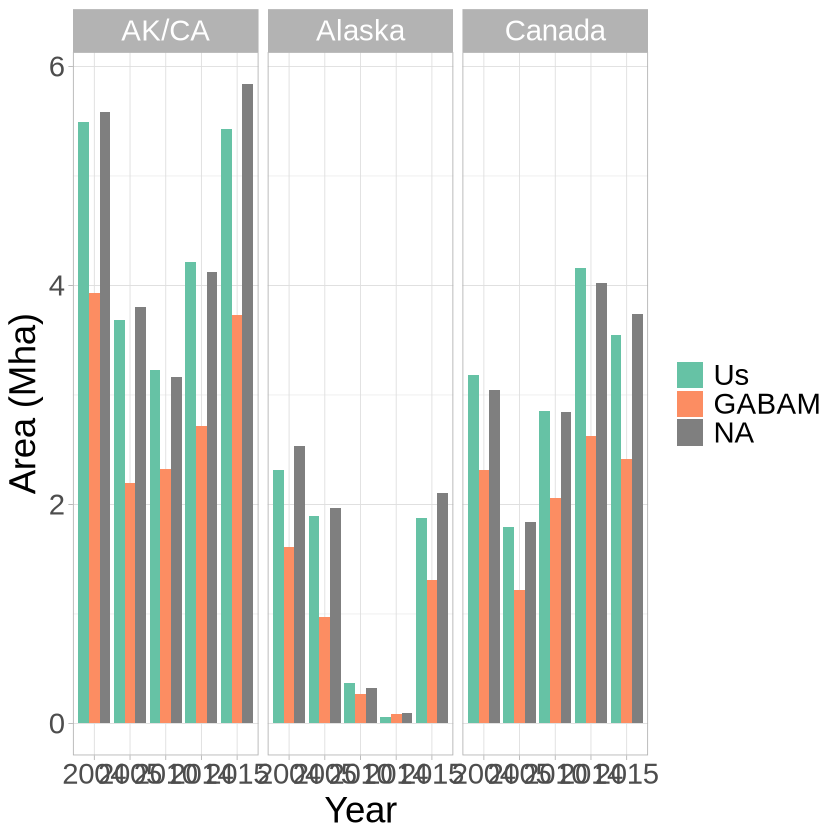

In [2]:
land2 = land2 %>% mutate(Class = factor(Class, levels = c('Ground Truth', 'Us', 'GABAM')))

p = ggplot(data = land2, aes(x = as.factor(Year), y = Area, fill = Class)) + 
         scale_fill_manual(values = c('#66c2a5', '#fc8d62', '#8da0cb')) + 
         geom_bar(stat = 'identity', position = position_dodge())  +
         facet_wrap(~AOI, ncol = 3) + 
         theme_light() +   
         labs(x = 'Year', y = 'Area (Mha)') + 
          theme(legend.title=element_blank()) + 
         theme(text=element_text(size=22)) 

ggsave(p, filename = file.path(out, 'landsat2.png'), device = "png", dpi = 150, width = 15, height = 12)

p

Combine modis and landsat

Rows: 20 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Class, AOI
dbl (2): Year, Area

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Class', 'AOI'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Class'. You can override using the
`.groups` argument.
Rows: 4725301 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Class, AOI
dbl (2): Area, Year

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Class', 'AOI'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Class'. You can override using the
`.groups` a

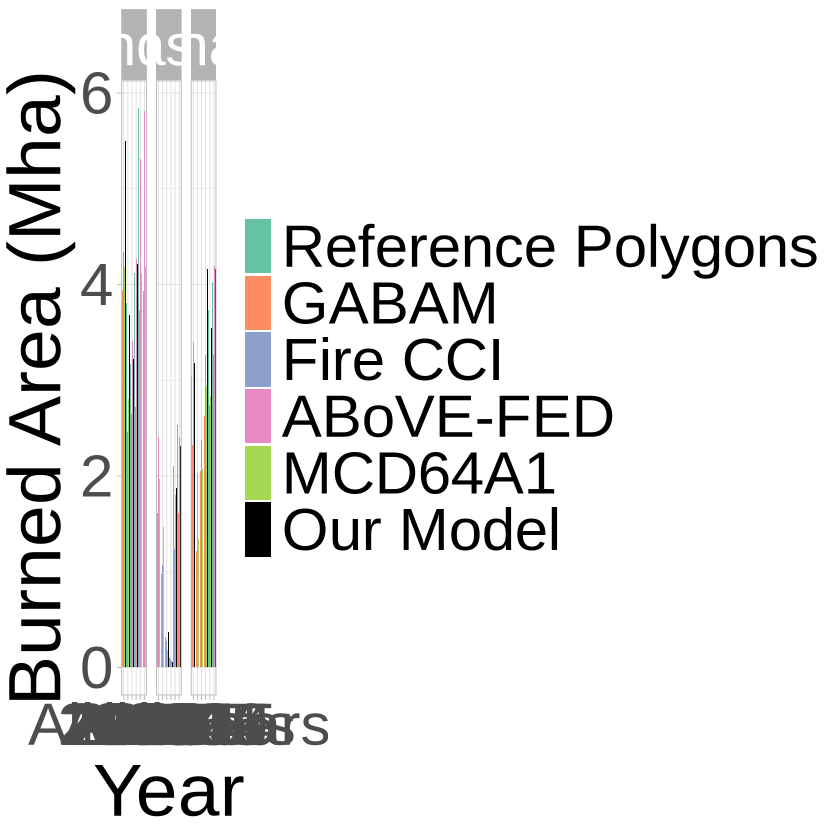

In [2]:
# modis2 = modis %>% filter(Year == 2004)
library(tidyverse)


modis = read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons/modis_ee.csv') %>% filter(Class != 'Fire_CCI')





# modis = read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons/modis.csv')
modis = modis %>% mutate(AOI = ifelse(AOI == 'AK', 'Alaska', 'Canada'))

#group by Year, AOI and Class and sum area, then turn from m2 to Mha
modis = modis %>% 
        group_by(Class, AOI, Year) %>% 
        dplyr::summarize(Area = sum(Area)) #%>%
        #mutate(Area = Area * 0.0001 / 1e6)

#now get combined ak and ca
comb = modis %>% 
       group_by(Class, Year) %>% 
       dplyr::summarize(Area = sum(Area)) %>%
       mutate(AOI = 'AK/CA') %>%
       select(names(modis))

modis = bind_rows(modis, comb)

modis = modis %>% mutate(AOI = factor(AOI, levels = c('AK/CA', 'Alaska', 'Canada')))

modis2 = read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons/modis.csv') %>%  filter(Class == 'ABoVE-FED')

modis2 = modis2 %>% mutate(AOI = ifelse(AOI == 'AK', 'Alaska', 'Canada'))

#group by Year, AOI and Class and sum area, then turn from m2 to Mha
modis2 = modis2 %>% 
        group_by(Class, AOI, Year) %>% 
        dplyr::summarize(Area = sum(Area)) %>%
        mutate(Area = Area * 0.0001 / 1e6)

#now get combined ak and ca
comb2 = modis2 %>% 
       group_by(Class, Year) %>% 
       dplyr::summarize(Area = sum(Area)) %>%
       mutate(AOI = 'AK/CA') %>%
       select(names(modis))

modis = bind_rows(modis, modis2, comb, comb2)

modis3 = read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons/fire_cci_wgs3.csv')


modis3 = modis3 %>% mutate(AOI = ifelse(AOI == 'AK', 'Alaska', 'Canada'))

#group by Year, AOI and Class and sum area, then turn from m2 to Mha
modis3 = modis3 %>% 
        group_by(Class, AOI, Year) %>% 
        dplyr::summarize(Area = sum(Area)) %>%
        mutate(Area = Area * 0.0001 / 1e6)

#now get combined ak and ca
comb3 = modis3 %>% 
       group_by(Class, Year) %>% 
       dplyr::summarize(Area = sum(Area)) %>%
       mutate(AOI = 'AK/CA') %>%
       select(names(modis))

modis = bind_rows(modis, modis2, comb, comb2, comb3, modis3)


# modis = modis %>% mutate(AOI = factor(AOI, levels = c('AK/CA', 'Alaska', 'Canada')))




for_comb = bind_rows(land2, modis)

for_comb = for_comb %>% mutate(Class = ifelse(Class == 'Us', 'Our Model', Class))
for_comb = for_comb %>% mutate(Class = ifelse(Class == 'Fire_CCI', 'Fire CCI', Class))


for_comb = for_comb %>% mutate(Class = factor(Class, levels = c('Reference Polygons', 'GABAM', 'Fire CCI', 'ABoVE-FED', 'MCD64A1', 'Our Model')))

# hline_values <- for_comb %>% filter(Class == 'Our Model')

#now get the mean burned area for across all years
all_mean = for_comb %>% group_by(Class, AOI, Area) %>% dplyr::summarize(Area = mean(Area, na.rm = T)) %>% mutate(Year = 'All Years')

for_comb = bind_rows(for_comb %>% mutate(Year = as.character(Year)), all_mean)

for_comb = for_comb %>% mutate(AOI = ifelse(AOI == 'AK/CA', 'Alaska and Canada', AOI))
for_comb = for_comb %>% mutate(AOI = factor(AOI, levels = c('Alaska and Canada', 'Alaska', 'Canada')))



p = ggplot(data = for_comb, aes(x = as.factor(Year), y = Area, fill = Class)) + 
         # scale_fill_manual(values = c('#66c2a5', '#fc8d62', '#8da0cb',   '#e78ac3', '#a6d854', '#ffd92f')) + 
         scale_fill_manual(values = c('#66c2a5', '#fc8d62', '#8da0cb',   '#e78ac3', '#a6d854', 'black')) + 

         geom_bar(stat = 'identity', position = position_dodge())  +
         # geom_hline(data = hline_values, aes(yintercept = Area), linetype = 2, color = "red") +
         facet_wrap(~AOI, ncol = 3) + 
         theme_light() +   
         labs(x = 'Year', y = 'Burned Area (Mha)') + 
        theme(legend.title=element_blank()) + 
         theme(text=element_text(size=45)) 

# ggsave(p, filename = file.path(out, 'landsat_modis_comb3.png'), device = "png", dpi = 150, width = 46, height = 15)
ggsave(p, filename = file.path('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/landsat_modis_comb3.png'), device = "png", dpi = 150, width = 46, height = 15)

p

write_csv(for_comb, '/explore/nobackup/people/spotter5/viirs_nrt/cnn_areas.csv')

Class,AOI,Year,Area
<fct>,<fct>,<chr>,<dbl>
GABAM,Alaska,2004,1.60951995
GABAM,Alaska,2005,0.97510815
GABAM,Alaska,2010,0.26962245
GABAM,Alaska,2014,0.08713845
GABAM,Alaska,2015,1.31359995
GABAM,Canada,2004,2.31853851


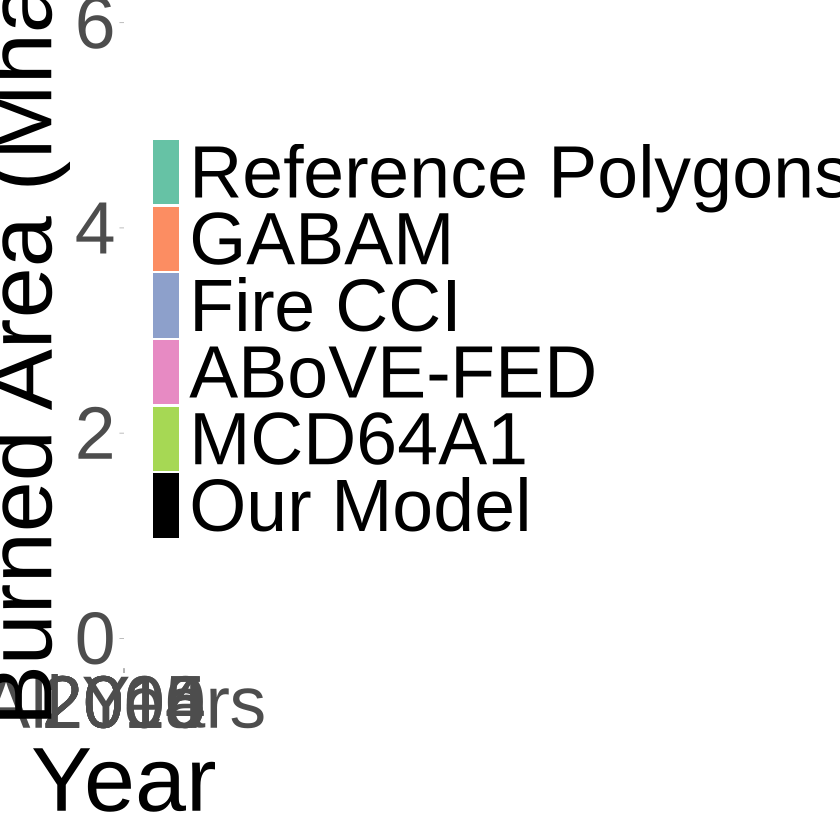

In [7]:
#just alaska and Canada for ABoVE-meeting
head(for_comb)

p = ggplot(data = for_comb %>% filter(AOI == 'Alaska and Canada') , aes(x = as.factor(Year), y = Area, fill = Class)) + 
         # scale_fill_manual(values = c('#66c2a5', '#fc8d62', '#8da0cb',   '#e78ac3', '#a6d854', '#ffd92f')) + 
         scale_fill_manual(values = c('#66c2a5', '#fc8d62', '#8da0cb',   '#e78ac3', '#a6d854', 'black')) + 

         geom_bar(stat = 'identity', position = position_dodge())  +
         # geom_hline(data = hline_values, aes(yintercept = Area), linetype = 2, color = "red") +
         # facet_wrap(~AOI, ncol = 3) + 
         theme_light() +   
         labs(x = 'Year', y = 'Burned Area (Mha)') + 
        theme(legend.title=element_blank()) + 
         theme(text=element_text(size=55)) 

p
# # ggsave(p, filename = file.path(out, 'landsat_modis_comb3.png'), device = "png", dpi = 150, width = 46, height = 15)
ggsave(p, filename = file.path('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/landsat_modis_comb_ak_ca.png'), device = "png", dpi = 150, width = 42, height = 16)



In [4]:
unique(for_comb$AOI)

[1] Alaska            Canada            Alaska and Canada
Levels: Alaska and Canada Alaska Canada

In [20]:
modis = read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons/modis_ee.csv') %>% filter(Class != 'Fire_CCI')
unique(modis$Class)

Rows: 20 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Class, AOI
dbl (2): Year, Area

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "MCD64A1"

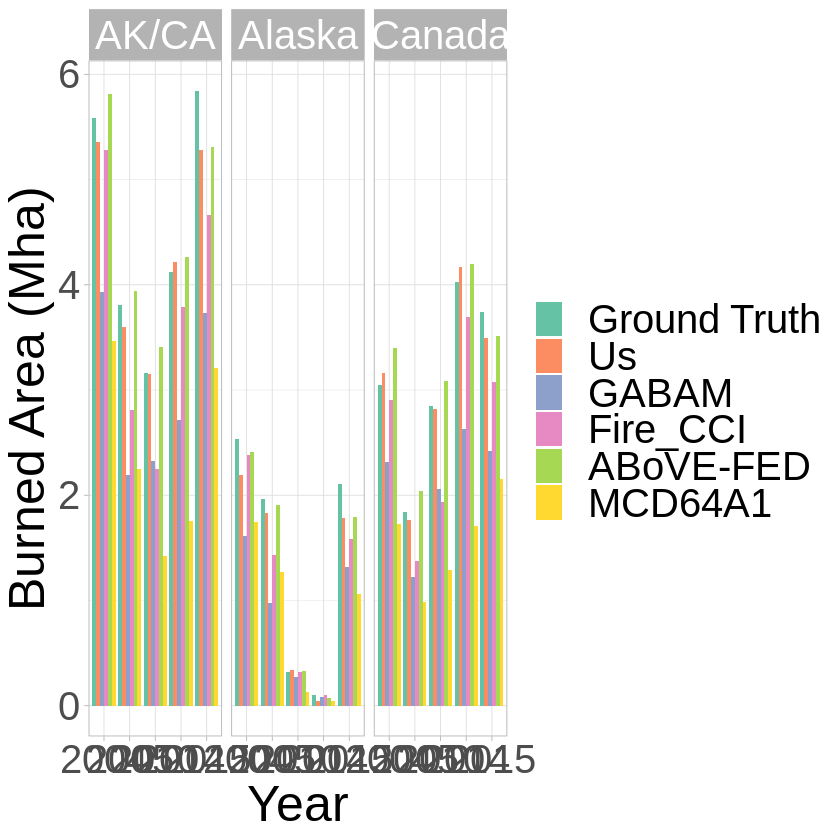

In [15]:
p = ggplot(data = for_comb, aes(x = as.factor(Year), y = Area, fill = Class)) + 
         scale_fill_manual(values = c('#66c2a5', '#fc8d62', '#8da0cb',   '#e78ac3', '#a6d854', '#ffd92f')) + 
         geom_bar(stat = 'identity', position = position_dodge())  +
         facet_wrap(~AOI, ncol = 3) + 
         theme_light() +   
         labs(x = 'Year', y = 'Burned Area (Mha)') + 
        theme(legend.title=element_blank()) + 
         theme(text=element_text(size=30)) 

ggsave(p, filename = file.path(out, 'landsat_modis_comb.png'), device = "png", dpi = 150, width = 40, height = 15)

p

Now plot out the int, omissoin and comission for us and gabam

In [8]:
#note Have is us or gabam have fire but ground truth does not, while Not means ground truth has fire be we do not
land3 = land %>% filter(Class %in% c('Us-Intersection', 'GABAM-Intersection', 'Us-Have', 'GABAM-Have', 'Us-Not', 'GABAM-Not'))

land3 = land3 %>% 
        group_by(Class, AOI, Year) %>% 
        dplyr::summarize(Area = sum(Area)) %>%
        mutate(Area = Area * 0.0001 / 1e6)

#get combined ak and ca
comb = land3 %>% 
       group_by(Class, Year) %>% 
       dplyr::summarize(Area = sum(Area)) %>%
       mutate(AOI = 'AK/CA') %>%
       select(names(land3))

land3 = bind_rows(land3, comb)

land3 = land3 %>% mutate(AOI = factor(AOI, levels = c('AK/CA', 'AK', 'CA')))

land3



`summarise()` has grouped output by 'Class', 'AOI'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Class'. You can override using the
`.groups` argument.


Class,AOI,Year,Area
<chr>,<fct>,<dbl>,<dbl>
GABAM-Have,AK,2004,0.03922497
GABAM-Have,AK,2005,0.09251001
GABAM-Have,AK,2010,0.08171244
GABAM-Have,AK,2014,0.02720115
GABAM-Have,AK,2015,0.01766979
GABAM-Have,CA,2004,0.31993389
GABAM-Have,CA,2005,0.07194366
GABAM-Have,CA,2010,0.11169099
GABAM-Have,CA,2014,0.13419396


In [9]:
't'

[1] "t"

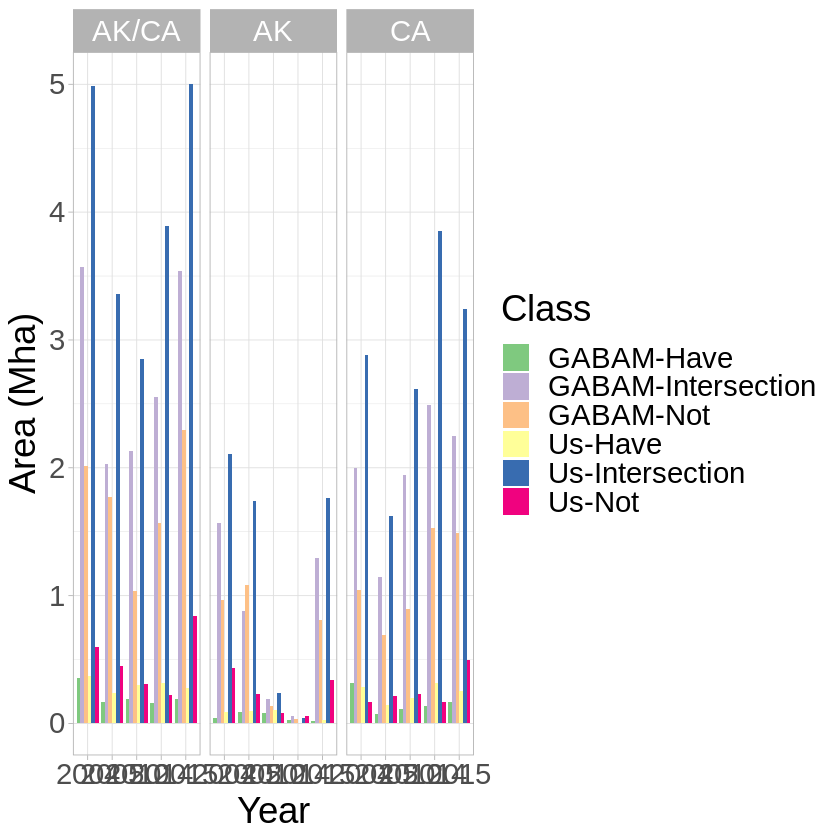

In [7]:
p = ggplot(data = land3, aes(x = as.factor(Year), y = Area, fill = Class)) + 
         geom_bar(stat = 'identity', position = position_dodge())  +
         facet_wrap(~AOI, ncol = 3) + 
         scale_fill_manual(values = c('#7fc97f', '#beaed4', '#fdc086',   '#ffff99', '#386cb0', '#f0027f')) + 
         theme_light() +   
         labs(x = 'Year', y = 'Area (Mha)') + 
         theme(text=element_text(size=22))

# ggsave(p, filename = file.path(out, 'landsat_om_com.png'), device = "png", dpi = 150, width = 15, height = 12)

p

In [10]:
confusion_matrix = land3 %>%
        filter(AOI == 'AK') %>%
        group_by(Class) %>%
        summarize(Area = sum(Area))
                  
gabam_ak_tot = confusion_matrix %>% 
    filter(Class %in% c('GABAM-Have', 'GABAM-Intersection', 'GABAM-Not')) %>%
    mutate(Total = sum(Area)) %>% 
    mutate(Percent = Area / Total)

gabam_ak_tot

Class,Area,Total,Percent
<chr>,<dbl>,<dbl>,<dbl>
GABAM-Have,0.2583184,7.282785,0.03546972
GABAM-Intersection,3.9966706,7.282785,0.54878325
GABAM-Not,3.0277964,7.282785,0.41574703


In [11]:
confusion_matrix = land3 %>%
        filter(AOI == 'CA') %>%
        group_by(Class) %>%
        summarize(Area = sum(Area))
                  
gabam_ca_tot = confusion_matrix %>% 
    filter(Class %in% c('GABAM-Have', 'GABAM-Intersection', 'GABAM-Not')) %>%
    mutate(Total = sum(Area)) %>% 
    mutate(Percent = Area / Total)

gabam_ca_tot

Class,Area,Total,Percent
<chr>,<dbl>,<dbl>,<dbl>
GABAM-Have,0.8074927,16.29397,0.04955776
GABAM-Intersection,9.8340013,16.29397,0.60353618
GABAM-Not,5.6524775,16.29397,0.34690606


In [12]:
confusion_matrix = land3 %>%
        filter(AOI == 'AK') %>%
        group_by(Class) %>%
        summarize(Area = sum(Area))
                  
us_ak_tot = confusion_matrix %>% 
    filter(Class %in% c('Us-Have', 'Us-Intersection', 'Us-Not')) %>%
    mutate(Total = sum(Area)) %>% 
    mutate(Percent = Area / Total)

us_ak_tot

Class,Area,Total,Percent
<chr>,<dbl>,<dbl>,<dbl>
Us-Have,0.3509418,7.37407,0.04759132
Us-Intersection,6.1616021,7.37407,0.83557678
Us-Not,0.8615266,7.37407,0.11683189


In [13]:
confusion_matrix = land3 %>%
        filter(AOI == 'CA') %>%
        group_by(Class) %>%
        summarize(Area = sum(Area))
                  
us_ca_tot = confusion_matrix %>% 
    filter(Class %in% c('Us-Have', 'Us-Intersection', 'Us-Not')) %>%
    mutate(Total = sum(Area)) %>% 
    mutate(Percent = Area / Total)

us_ca_tot

Class,Area,Total,Percent
<chr>,<dbl>,<dbl>,<dbl>
Us-Have,1.123771,16.60815,0.06766379
Us-Intersection,14.404643,16.60815,0.86732359
Us-Not,1.079739,16.60815,0.06501262


In [19]:
0.05 * 100

[1] 5

In [56]:
library(tidyverse)
years = c(2004, 2005, 2010, 2014, 2015)

in_path = '/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons/fire_cci_raw'

modis2 = list()
for (year in years){
    
    all_files= list.files(file.path(in_path, year),
                          full.names = F, pattern = "*.csv") 
    
    for(f in all_files){
        
        df = read_csv(file.path(in_path, year,  f))
        
        if(nrow(df) >0){
                      
            df$Year = year

            modis2[[length(modis2) + 1]] = df

        }
    }
        
        
    
    
}
                      
modis2 = bind_rows(modis2)  

write_csv(modis2, '/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons/fire_cci_wgs3.csv')

Rows: 183 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Class, AOI
dbl (2): Area, Year

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 0 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Area, Class, AOI, Year

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 0 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Area, Class, AOI, Year

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 0 Columns: 4
── Column specification ─────────────────────────────────────────

In [50]:
library(tidyverse)
df = read_csv('/explore/nobackup/people/spotter5/cnn_mapping/raw_files/Stats_RUS_BA2.csv') %>% rename('Product' = '...1')

# df
# p = ggplot(data = df, aes(x = as.factor(Year), y = Area, fill = Class)) + 
#          # scale_fill_manual(values = c('#66c2a5', '#fc8d62', '#8da0cb',   '#e78ac3', '#a6d854', '#ffd92f')) + 
#          geom_bar(stat = 'identity', position = position_dodge())  +
#          facet_wrap(~AOI, ncol = 3) + 
#          theme_light() +   
#          labs(x = 'Year', y = 'Burned Area (Mha)') + 
#         theme(legend.title=element_blank()) + 
#          theme(text=element_text(size=30)) 

# ggsave(p, filename = file.path(out, 'landsat_modis_comb.png'), device = "png", dpi = 150, width = 40, height = 15)


New names:
• `` -> `...1`
Rows: 92 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ...1
dbl (20): 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Warning message in dir.create(out_path, recursive = T):
“'/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons' already exists”
Warning message:
“Removed 12 row(s) containing missing values (geom_path).”
Warning message:
“Removed 12 row(s) containing missing values (geom_path).”


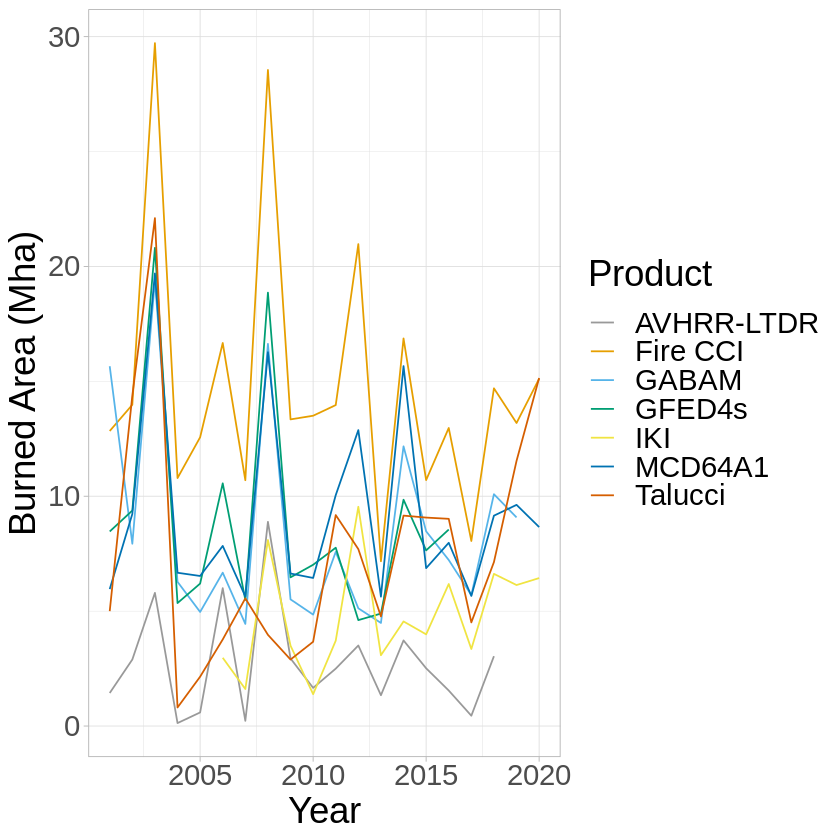

In [53]:
prods = c('Fire CCI', 'MCD64A1',  'GFED4s', 'IKI', 'AVHRR-LTDR', 'Talucci', 'GABAM')

df2 = df %>% filter(Product %in% prods)


df2 = df2 %>%
  pivot_longer(cols = -Product, 
               names_to = "Year", 
               values_to = "Value")

# df2

colors = c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00")

p = ggplot(data = df2, aes(x = as.numeric(Year), y = Value, color = Product)) + 
         geom_line() + 
         # geom_bar(stat = 'identity', position = position_dodge())  +
         # facet_wrap(~AOI, ncol = 3) + 
         scale_color_manual(values = colors) + 
         theme_light() +   
         labs(x = 'Year', y = 'Burned Area (Mha)') + 
         theme(text=element_text(size=22))

out_path = '/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons'
dir.create(out_path, recursive = T)

ggsave(p, filename = file.path(out_path, 'russia.png'), device = "png", dpi = 150, width = 18, height = 15)

p

In [14]:
prods

[1] "Fire_cci_masked" "MCD64A1"         "Talucci"         "GFED4s"         
[5] "IKI"             "NASA-AVHRR"      "GABAM"           "Total"

In [27]:
names(df2)

[1] "Class" "2001"  "2002"  "2003"  "2004"  "2005"  "2006"  "2007"  "2008" 
[10] "2009"  "2010"  "2011"  "2012"  "2013"  "2014"  "2015"  "2016"  "2017" 
[19] "2018"  "2019"  "2020"

In [31]:
df

Class,2001,2002,2003,2004,2005,2006,2007,2008,2009,⋯,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Urals,1.570750e+05,4.522305e+04,1.461687e+05,4.902299e+05,1.430205e+05,4.340277e+05,9.239389e+04,6.170553e+05,2.217528e+05,⋯,1.546275e+05,4.090614e+05,7.419607e+04,1.239606e+05,6.559159e+04,1.304354e+05,1.099510e+05,1.159578e+05,6.208427e+04,4.723229e+04
Siberia,4.877652e+05,5.970413e+05,9.056015e+05,6.396721e+05,6.150070e+05,1.070608e+06,5.342700e+05,1.368715e+06,8.362390e+05,⋯,6.709426e+05,1.292113e+06,2.138239e+05,8.933468e+05,3.144618e+05,6.176948e+05,4.379354e+05,2.994092e+05,6.939904e+05,7.756356e+05
Far East 1,1.297428e+06,1.397068e+06,2.271179e+06,5.456721e+05,1.087863e+06,8.935330e+05,6.816796e+05,1.929016e+06,9.724350e+05,⋯,1.164127e+06,1.409754e+06,7.581328e+05,1.364168e+06,8.228760e+05,1.172989e+06,6.230413e+05,1.788067e+06,1.148721e+06,1.382336e+06
Far East 2,1.119170e+05,1.975490e+05,1.431831e+06,5.100913e+04,1.645696e+05,2.688371e+05,4.032202e+05,6.531233e+05,1.046332e+05,⋯,2.450437e+05,2.444974e+05,1.008756e+05,3.170764e+05,5.094755e+05,1.541187e+05,1.175131e+05,1.478971e+05,2.051125e+05,2.126983e+05
Fire CCI,2.054185e+06,2.236881e+06,4.754780e+06,1.726583e+06,2.010460e+06,2.667006e+06,1.711564e+06,4.567910e+06,2.135060e+06,⋯,2.234740e+06,3.355426e+06,1.147028e+06,2.698552e+06,1.712405e+06,2.075238e+06,1.288441e+06,2.351331e+06,2.109908e+06,2.417902e+06
Square m,1.283870e+11,1.398050e+11,2.971740e+11,1.079110e+11,1.256540e+11,1.666880e+11,1.069730e+11,2.854940e+11,1.334410e+11,⋯,1.396710e+11,2.097140e+11,7.168927e+10,1.686590e+11,1.070250e+11,1.297020e+11,8.052755e+10,1.469580e+11,1.318690e+11,1.511190e+11
Mhec,1.283866e+01,1.398051e+01,2.971738e+01,1.079115e+01,1.256537e+01,1.666879e+01,1.069727e+01,2.854944e+01,1.334412e+01,⋯,1.396713e+01,2.097141e+01,7.168927e+00,1.686595e+01,1.070253e+01,1.297024e+01,8.052755e+00,1.469582e+01,1.318693e+01,1.511189e+01
Mhec - Urals,1.185694e+01,1.369786e+01,2.880382e+01,7.727208e+00,1.167150e+01,1.395612e+01,1.011981e+01,2.469284e+01,1.195817e+01,⋯,1.300071e+01,1.841478e+01,6.705202e+00,1.609119e+01,1.029258e+01,1.215502e+01,7.365561e+00,1.397108e+01,1.279890e+01,1.481669e+01
Talsib,6.064693e+04,1.900506e+05,4.878019e+05,1.122736e+05,1.507189e+05,3.237490e+05,1.853843e+05,3.571130e+05,9.929328e+04,⋯,2.517174e+05,4.276905e+05,1.549124e+05,3.649533e+05,1.648345e+05,5.114913e+05,2.274333e+05,1.850657e+05,4.623729e+05,1.512086e+05
